In [1]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import numpy as np
from collections import Counter
from plotnine import ggplot, aes, geom_bar, coord_flip, labs, theme_classic, scale_y_continuous, scale_color_discrete, guides, geom_col, scale_fill_manual 
import seaborn as sns

/home/djl294/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


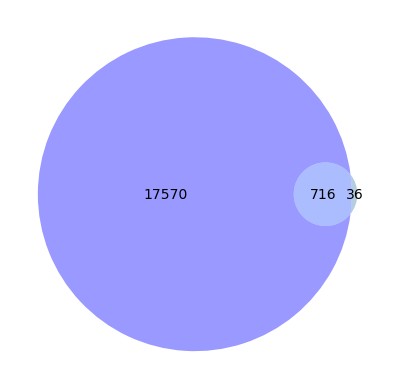

In [2]:
### Read the unique identifier files from FoldSeek and HMMER search, display overlap as venn diagram

def read_identifiers(file):
    with open(file, 'r') as f:
        lis = []
        lines = f.readlines()
        for line in lines:
            identifier = line.strip()
            lis.append(identifier)
        return set(lis)
        


# Read identifiers from the two files
fs_identifiers = read_identifiers("FS_tacc_Qcov80.u") # Target accessions of foldseekk hits (after quality filtering)
hmmer_identifiers = read_identifiers("HMMER_tacc.u")# Target accessions of hmmer hits (after quality filtering)


# Create a Venn diagram
venn2([fs_identifiers, hmmer_identifiers], ('', ''), set_colors=("Blue", "steelblue"))


# Display the plot
plt.title("")
plt.savefig("Foldseek_HMMER_venn.svg")
plt.show()

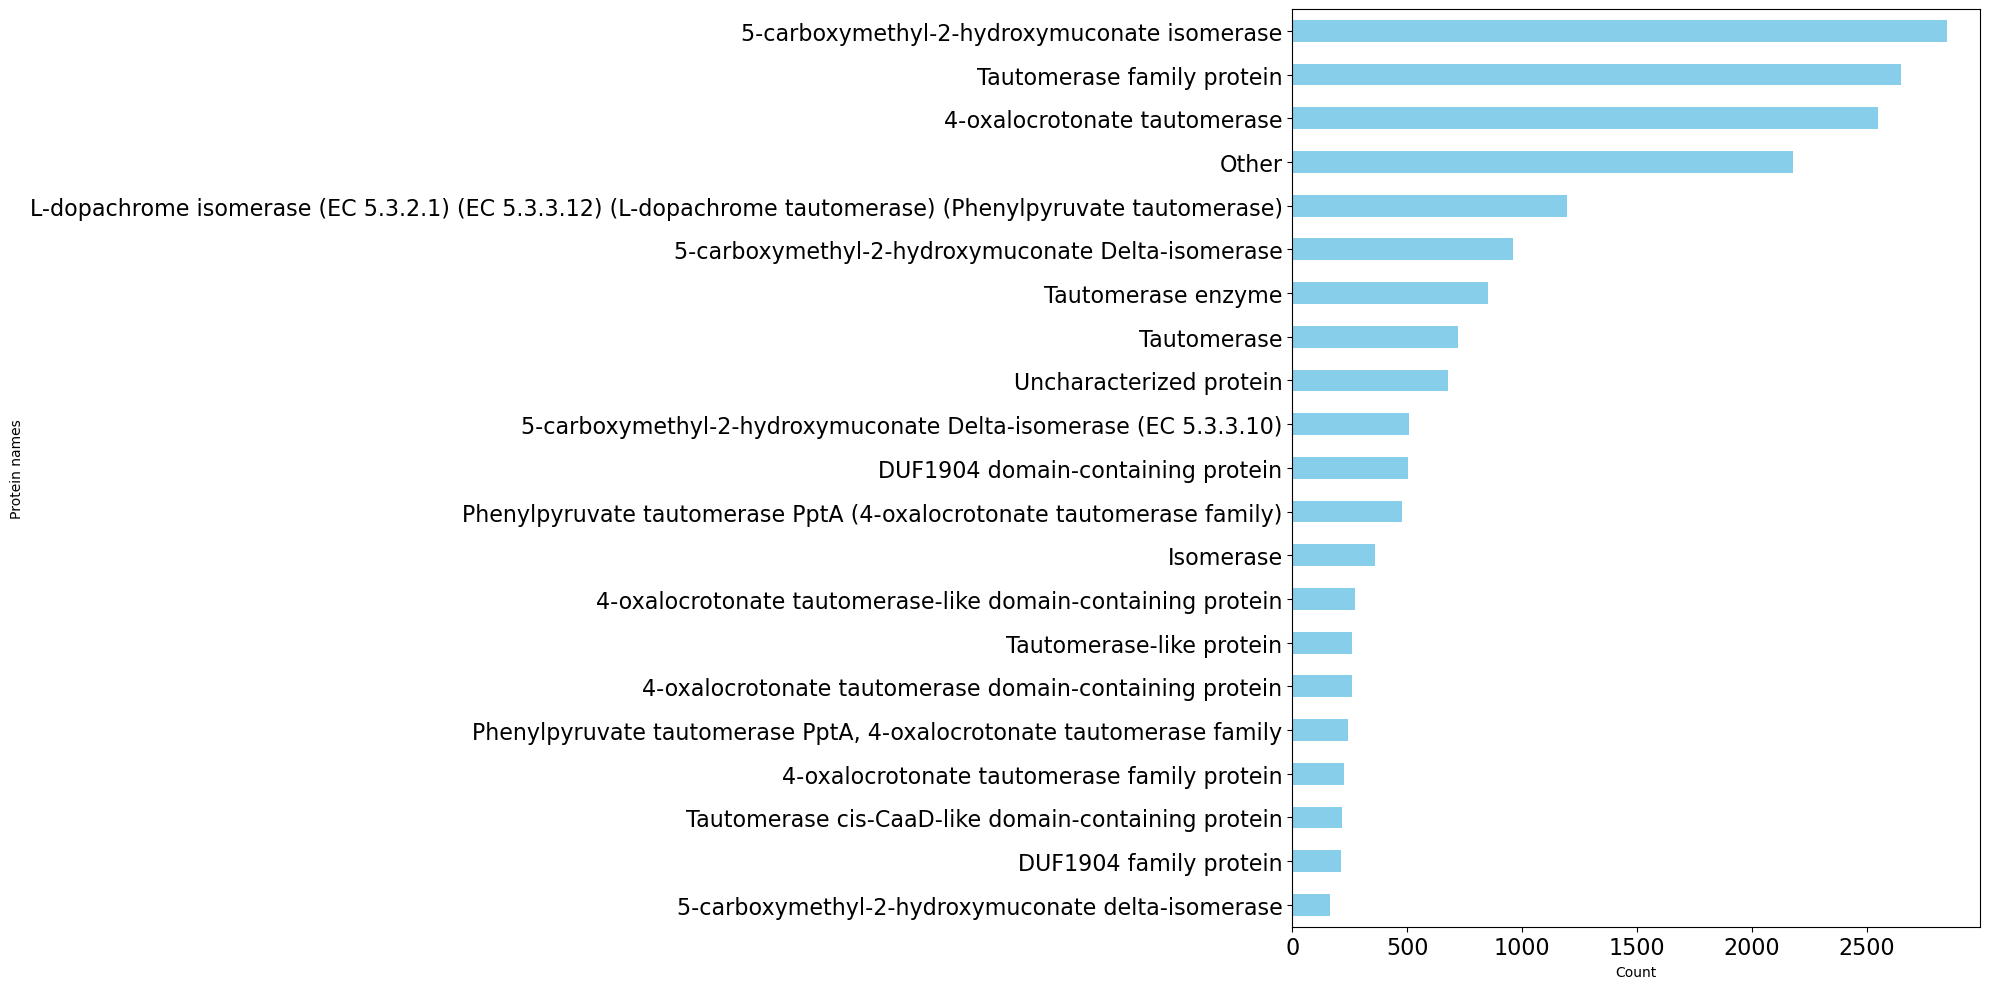

Protein names
5-carboxymethyl-2-hydroxymuconate isomerase                                                                  2850
Tautomerase family protein                                                                                   2649
4-oxalocrotonate tautomerase                                                                                 2549
L-dopachrome isomerase (EC 5.3.2.1) (EC 5.3.3.12) (L-dopachrome tautomerase) (Phenylpyruvate tautomerase)    1195
5-carboxymethyl-2-hydroxymuconate Delta-isomerase                                                             962
Tautomerase enzyme                                                                                            850
Tautomerase                                                                                                   721
Uncharacterized protein                                                                                       676
5-carboxymethyl-2-hydroxymuconate Delta-isomerase (EC 5.3.3.10)           

In [3]:
### Read and graph uniprot protein name annotations for each MIF

# Load data
names = pd.read_csv("combined_uniprot_protnames_Qcov80", sep="\t")

# Count occurrences of each protein name
protein_counts = names['Protein names'].value_counts()

# Optional: Limit to top N to avoid clutter
top_n = 20
protein_counts_top = protein_counts.nlargest(top_n)
other_count = protein_counts.iloc[top_n:].sum()
protein_counts_top['Other'] = other_count

# Plot horizontal bar chart
plt.figure(figsize=(20, 10))
protein_counts_top.sort_values().plot.barh(color='skyblue', fontsize=16)  # sort for visual clarity

plt.xlabel("Count")
#plt.title("Top Protein Names in Dataset", fontsize=16)
plt.tight_layout()
plt.savefig("protein_names_bar.svg")
plt.show()

print(protein_counts_top)



In [4]:
## Get Taxa  data for each accesion


acc2taxid = {}
df_taxa = pd.read_csv("tmp.tacc2txid.qcov80.u", sep="\t") #target accession (Uniref90 Representative) to NCBI_identifier mapping, from UniProts Mapping Tool


#Turn UniProt Mapping to Python Dict
for index, row in df_taxa.iterrows():
    acc = row[0]
    tax_id = row[2]
    acc2taxid[acc] = tax_id
acc2taxid    

/tmp/ipykernel_1469565/1996403804.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_1469565/1996403804.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


{'A0A009H1Z0': 1310608,
 'A0A009HCT7': 1310608,
 'A0A009HRD8': 1310613,
 'A0A009I523': 1310613,
 'A0A009N468': 1310652,
 'A0A009N6V0': 1310652,
 'A0A009PD57': 1310607,
 'A0A009QCK8': 1310607,
 'A0A009R8H0': 1310637,
 'A0A009RT57': 1310637,
 'A0A009SI62': 1310630,
 'A0A009TGX8': 1310630,
 'A0A009YTH9': 1310601,
 'A0A009ZCB5': 1310601,
 'A0A010INF0': 1310681,
 'A0A010JMD3': 1310681,
 'A0A010RN88': 1042209,
 'A0A011MJ67': 85402,
 'A0A011UXL5': 1341156,
 'A0A011VUM0': 1341156,
 'A0A013T945': 1310791,
 'A0A013TCJ8': 1310791,
 'A0A013TSB9': 1310764,
 'A0A013UUB9': 1310764,
 'A0A014KZH8': 1158056,
 'A0A014L8W3': 1158056,
 'A0A014MBQ3': 69222,
 'A0A014ME04': 1158056,
 'A0A014MEZ2': 1158056,
 'A0A014Q9J3': 1457173,
 'A0A016XD06': 1458275,
 'A0A016XKK4': 1458275,
 'A0A017HPD5': 442562,
 'A0A017RWW7': 1403537,
 'A0A017T4D9': 1192034,
 'A0A021VSG6': 948458,
 'A0A021X158': 1410620,
 'A0A021X2N5': 1410620,
 'A0A022FWJ5': 574750,
 'A0A022G2K5': 574750,
 'A0A022GKV3': 574750,
 'A0A022J069': 1310723,
 

In [6]:
### Get taxonomy summary file for each MIF NCBI id and combine into one dataframe; save output so we don't have to repeat

"""
cols = [
    "Query", "Taxid", "Tax name", "Authority", "Rank", "Basionym", "Basionym authority",
    "Curator common name", "Has type material", "Group name", "Superkingdom name", "Superkingdom taxid",
    "Kingdom name", "Kingdom taxid", "Phylum name", "Phylum taxid", "Class name", "Class taxid",
    "Order name", "Order taxid", "Family name", "Family taxid", "Genus name", "Genus taxid",
    "Species name", "Species taxid", "Scientific name is formal"
]

# List to collect each DataFrame for better performance
df_list = []
accs = []
exceptions = []

for key, value in acc2taxid.items():
    try:
        path = f'/workdir/djl294/NCBI_tax_MIF/{value}/ncbi_dataset/data/taxonomy_summary.tsv'
        summary_df = pd.read_csv(path, sep="\t")
        summary_df["ACC"] = key  # Add ACC column directly here
        df_list.append(summary_df)
        accs.append(key)
    except Exception as e:
        print(f'{value} error: {e}')
        exceptions.append(value)

# Concatenate all DataFrames and write to CSV
combined_taxa_df = pd.concat(df_list, ignore_index=True)
combined_taxa_df.to_csv("combined_taxa_output.csv", index=False)

# Optional: show or return the DataFrame if desired
combined_taxa_df

"""

combined_taxa_df = pd.read_csv("combined_taxa_output.csv")
combined_taxa_df 


50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
50340 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/50340/ncbi_dataset/data/taxonomy_summary.tsv'
404407 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/404407/ncbi_dataset/data/taxonomy_summary.tsv'
68044 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/68044/ncbi_dataset/data/taxonomy_summary.tsv'
68044 error: [Errno 2] No such file or directory: '/workdir/djl294/NCBI_tax_MIF/68044/ncbi_dataset/data/taxonomy_sum

'\n\ncombined_taxa_df = pd.read_csv("combined_taxa_output.csv")\ncombined_taxa_df \n'

In [7]:
### For a given taxanomic level, make a sub-dataframe for plotting

def get_taxa_ratios(df, Target_Taxa):
    Target_Taxa_List = []
    level_index = df.columns.get_loc(Target_Taxa)
    for i, row in df.iterrows():
        tax_name = row[level_index]
        Target_Taxa_List.append(tax_name)
        
          
    counts = Counter(Target_Taxa_List)
    #print(Target_Taxa_List)

    total_counts = sum(list(counts.values()))
    
    
    
    percent_dict = {}
    for key, value in counts.items():
        percent = value/total_counts * 100
        percent_dict[key] = percent
    #print(percent_dict)
        
    n = len(percent_dict.keys())
    Levels = [Target_Taxa] * n
    sub_df = pd.DataFrame({
        "Level": Levels,
        "Label": percent_dict.keys(),
        "Perc": percent_dict.values()
    })
    
    return sub_df
    


phylum_plot_df = get_taxa_ratios(combined_taxa_df, "Phylum name")
  
print(phylum_plot_df)
    
    
    
family_plot_df = get_taxa_ratios(combined_taxa_df, "Family name")
  
print(family_plot_df)
    
genus_plot_df = get_taxa_ratios(combined_taxa_df, "Genus name")
  
print(genus_plot_df)

species_plot_df = get_taxa_ratios(combined_taxa_df, "Species name")
  
print(species_plot_df)

/tmp/ipykernel_1469565/330031078.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


          Level                              Label       Perc
0   Phylum name                     Pseudomonadota  60.752512
1   Phylum name                          Bacillota  10.326562
2   Phylum name                     Actinomycetota  18.184797
3   Phylum name                        Myxococcota   0.447794
4   Phylum name                       Bacteroidota   2.561162
..          ...                                ...        ...
66  Phylum name                     Fibrobacterota   0.016383
67  Phylum name                    Fidelibacterota   0.005461
68  Phylum name  Candidatus Handelsmaniibacteriota   0.005461
69  Phylum name        Candidatus Rifleibacteriota   0.005461
70  Phylum name                      Chrysiogenota   0.005461

[71 rows x 3 columns]


/tmp/ipykernel_1469565/330031078.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


           Level                       Label      Perc
0    Family name               Moraxellaceae  2.839668
1    Family name            Pseudomonadaceae  6.269113
2    Family name             Pasteurellaceae  0.578855
3    Family name            Oscillospiraceae  0.540629
4    Family name           Streptomycetaceae  6.280035
..           ...                         ...       ...
415  Family name          Geitlerinemataceae  0.005461
416  Family name               Xenococcaceae  0.005461
417  Family name  Candidatus Korobacteraceae  0.005461
418  Family name          Symbiobacteriaceae  0.005461
419  Family name             Microthrixaceae  0.005461

[420 rows x 3 columns]


/tmp/ipykernel_1469565/330031078.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


           Level                     Label      Perc
0     Genus name             Acinetobacter  2.386413
1     Genus name               Pseudomonas  6.028834
2     Genus name                Mannheimia  0.043687
3     Genus name              Ruminococcus  0.212975
4     Genus name              Streptomyces  5.897772
...          ...                       ...       ...
1446  Genus name  Candidatus Competibacter  0.010922
1447  Genus name          Commensalibacter  0.005461
1448  Genus name           Intrasporangium  0.005461
1449  Genus name               Imhoffiella  0.005461
1450  Genus name         Agrilactobacillus  0.005461

[1451 rows x 3 columns]


/tmp/ipykernel_1469565/330031078.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


             Level                             Label      Perc
0     Species name         Acinetobacter sp. 1295259  0.010922
1     Species name           Acinetobacter baumannii  0.267584
2     Species name         Acinetobacter sp. 1475718  0.010922
3     Species name          Acinetobacter sp. 809848  0.010922
4     Species name          Acinetobacter sp. 479375  0.010922
...            ...                               ...       ...
8285  Species name           Marinomonas ushuaiensis  0.010922
8286  Species name            Fusobacterium sp. CM22  0.005461
8287  Species name           Fusobacterium sp. OBRC1  0.005461
8288  Species name             Fusobacterium sp. CM1  0.005461
8289  Species name  Brachybacterium phenoliresistens  0.010922

[8290 rows x 3 columns]


In [8]:
def plot_taxa_distribution(df, top_n=5, title_prefix=''):
    # Ensure 'Perc' is numeric
    df['Perc'] = pd.to_numeric(df['Perc'], errors='coerce')
    df = df.dropna(subset=['Perc'])

    valid_df = df.dropna(subset=['Label'])
    nan_label_perc = df[df['Label'].isna()]['Perc'].sum()

    df_sorted = valid_df.sort_values('Perc', ascending=False).reset_index(drop=True)
    top_df = df_sorted.iloc[:top_n].copy()
    other_perc = df_sorted.iloc[top_n:]['Perc'].sum() + nan_label_perc

    if other_perc > 0:
        other_row = pd.DataFrame([{
            'Level': top_df['Level'].iloc[0] if 'Level' in top_df.columns else '',
            'Label': 'Other',
            'Perc': other_perc
        }])
        top_df = pd.concat([top_df, other_row], ignore_index=True)

    # Define a consistent color palette
    colors = sns.color_palette('pastel', n_colors=len(top_df))
    
    # Polar Pie-style Plot (no label clutter, legend instead)
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111, polar=True)
    perc = top_df['Perc']
    labels = top_df['Label']
    total = perc.sum()
    angles = perc.cumsum() / total * 2 * np.pi
    widths = perc / total * 2 * np.pi
    start_angles = np.concatenate(([0], angles[:-1]))

    bars = ax.bar(x=start_angles + widths / 2, height=1, width=widths,
                  bottom=0.0, linewidth=1, edgecolor='white', color=colors)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{title_prefix}Taxa Distribution (Pie Chart)', y=1.1)

    # Add legend with percentages
    legend_labels = [f"{label}: {value:.1f}%" for label, value in zip(labels, perc)]
    ax.legend(bars, legend_labels, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=15)

    plt.tight_layout()
    out_pie = f'{title_prefix}_pie.svg'
    plt.savefig(out_pie)
    plt.show()

    # Horizontal Bar Chart using same colors
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_df, y='Label', x='Perc', palette=colors)
    plt.xlabel('Percentage')
    plt.title(f'{title_prefix}Taxa Distribution (Bar Chart)')
    plt.tight_layout()
    plt.show()

    return top_df

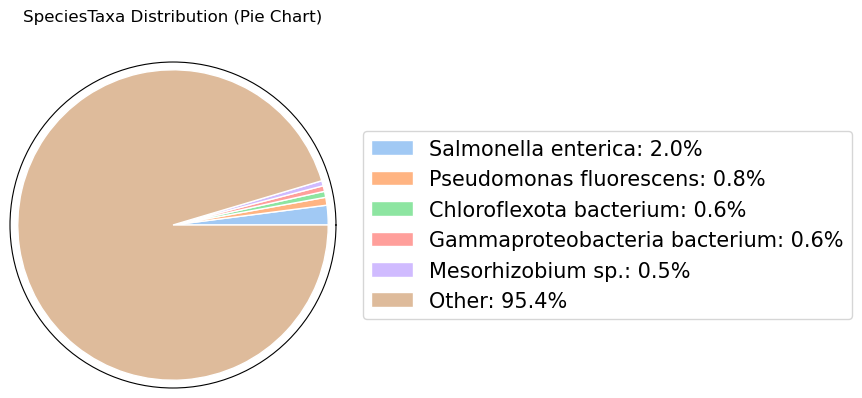

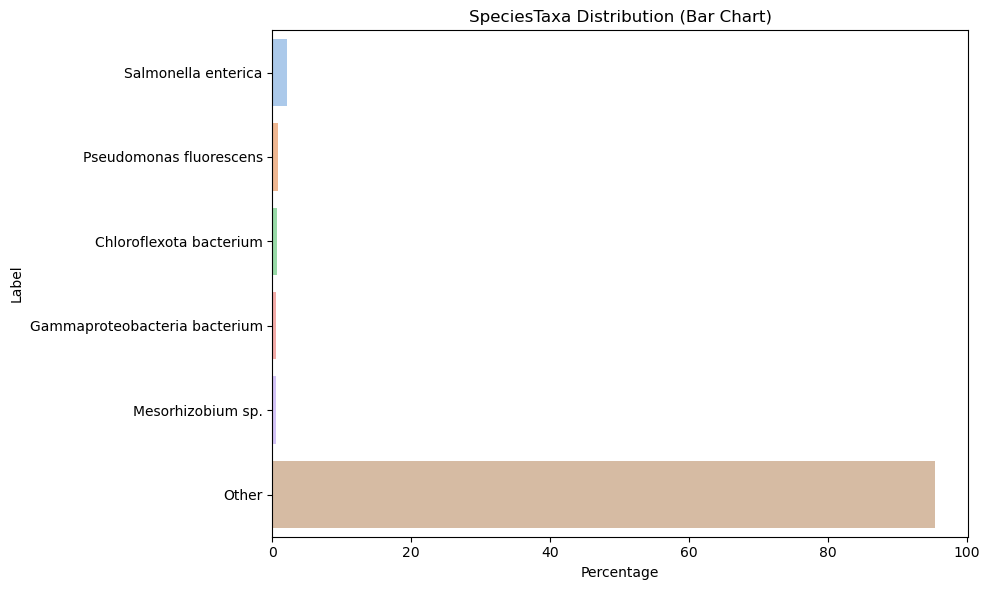

,Level,Label,Perc
0,Species name,Salmonella enterica,2.042377
1,Species name,Pseudomonas fluorescens,0.819135
2,Species name,Chloroflexota bacterium,0.622543
3,Species name,Gammaproteobacteria bacterium,0.584316
4,Species name,Mesorhizobium sp.,0.535168
5,Species name,Other,95.396461


In [12]:
plot_taxa_distribution(species_plot_df, top_n=5, title_prefix='Species')


In [51]:
### Parse the output from deeplocpro, print accession of "Extracellular" proteins

df_deeplocpro = pd.read_csv("deeplocpro_out/results_20250726-030536.csv")
df_deeplocpro


deeplocpro_secreted = []
for i, r in df_deeplocpro.iterrows():
    acc = str(r['ACC']).split("|")[1]
    if r['Localization'] == "Extracellular":
        print(acc)
        deeplocpro_secreted.append(acc)
    

A0A071MCE1
A0A0G1K7I5
A0A0G1RRC5
A0A0J5ZZK7
A0A106DBC2
A0A107QBE1
A0A1J4RVD8
A0A1W7D0T3
A0A2A4CKA2
A0A2A4R048
A0A2H0DT84
A0A2H0VK31
A0A2W4LB07
A0A364GZR7
A0A3D4CNU7
A0A3M2KYU5
A0A3N8HZI0
A0A3P0MLW5
A0A3P0NKS1
A0A495YQF8
A0A4R4AFZ5
A0A6L3NEU5
A0A6P2GE12
A0A6P3B8N2
A0A7C9BQH6
A0A7T1MH78
A0A7T6VLR4
A0A853B724
B4EL67
W0E6T2


In [50]:
### Parse the output from DEEPTMHMM, if any residues are outside of the cell, print the whole per-residue localization
def parse_file_into_blocks(filename):
    with open(filename, 'r') as file:
        block = []
        for counter, line in enumerate(file, start=1):
            block.append(line.rstrip('\n'))  # Append the line without the newline character
            if counter % 3 == 0:
                yield block
                block = []
        
        # If there are remaining lines that do not form a complete block at the end
        if block:
            yield block

blocks = []
for block in parse_file_into_blocks("deeptmhmm_results/predicted_topologies.3line"):
    id_string = str(block[0].split(" |")[0]).split(">")[1]
    residue_locs = block[2]
    if 'O' in residue_locs:
        print(id_string, residue_locs)
        #with open("deeptmhmm_extra_hits", "a+") as f_out:
        #          f_out.write(id_string)
        #          f_out.write("\n")
                    
    


In [52]:
#Read in the secreted uniprot identifiers
uniprot_secreted = []
with open("MIFs_UniProt_Secreted", 'r') as f:
    lines = f.readlines()
    for line in lines:
        acc = line.strip()
        uniprot_secreted.append(acc)
        
        
print(uniprot_secreted)  
    
  
    

['A0A011VUM0', 'A0A076HQJ4', 'A0A076JKV6', 'A0A078KTQ4', 'A0A084JL76', 'A0A086Z1W8', 'A0A086ZF21', 'A0A087AHD6', 'A0A087AN00', 'A0A087AP32', 'A0A087BRD1', 'A0A087C4Q1', 'A0A087CVX1', 'A0A087CYB6', 'A0A087CZE3', 'A0A087DRC9', 'A0A087E301', 'A0A087VSX0', 'A0A089PFU3', 'A0A096B5Q1', 'A0A096B5W9', 'A0A0A0BCX7', 'A0A0A1GR13', 'A0A0A1VZT2', 'A0A0A1ZAT1', 'A0A0A1ZYB9', 'A0A0A2A886', 'A0A0A2A8L2', 'A0A0A2AHU2', 'A0A0A2B5J2', 'A0A0A2BCY2', 'A0A0A2BGG5', 'A0A0A2BN57', 'A0A0A2C661', 'A0A0A2CF60', 'A0A0A6PHM1', 'A0A0A7I3P3', 'A0A0A7I624', 'A0A0B5QUH5', 'A0A0C1QV00', 'A0A0C1YCU0', 'A0A0D6AJX7', 'A0A0D6KNU9', 'A0A0D8IUR7', 'A0A0D8ZXV6', 'A0A0E2Z6W9', 'A0A0E3JMW4', 'A0A0F0CN72', 'A0A0F3IKW6', 'A0A0F4L0F5', 'A0A0F4L4M4', 'A0A0G3G3A4', 'A0A0H3E833', 'A0A0H3K6C5', 'A0A0H5SUZ0', 'A0A0J1G3E5', 'A0A0J8FDB6', 'A0A0J9C317', 'A0A0K1S7V7', 'A0A0M0VL25', 'A0A0M1JXU5', 'A0A0M2PQX8', 'A0A0N0V262', 'A0A0N8KMQ4', 'A0A0P7ZA40', 'A0A0P9EMF1', 'A0A0R2XLC5', 'A0A0S2HXF2', 'A0A0S2MG90', 'A0A0S2TE81', 'A0A0S3U0K2', 'A0A0

In [31]:
#Parse the signalP output , print the prediction types
df_signalp = pd.read_csv('signal_p/prediction_results.txt', sep="\t", skiprows=1)

print(df_signalp)
predictions = set(df_signalp['Prediction'])
print(f'Predictions: {predictions}')

                                                    # ID Prediction     OTHER  \
0      tr|A0A009H1Z0|A0A009H1Z0_9GAMM 5-carboxymethyl...      OTHER  1.000000   
1      tr|A0A009HCT7|A0A009HCT7_9GAMM Tautomerase enz...      OTHER  1.000000   
2      tr|A0A009HRD8|A0A009HRD8_ACIB9 5-carboxymethyl...      OTHER  1.000000   
3      tr|A0A009I523|A0A009I523_ACIB9 Tautomerase enz...      OTHER  1.000000   
4      tr|A0A009N468|A0A009N468_9GAMM 5-carboxymethyl...      OTHER  0.999998   
...                                                  ...        ...       ...   
17088  tr|X8DIB9|X8DIB9_9MYCO FG41 Malonate Semialdeh...      OTHER  0.999999   
17089  tr|X8GZX3|X8GZX3_9FUSO PF08921 domain protein ...      OTHER  0.999992   
17090  tr|X8HN85|X8HN85_9FUSO PF08921 domain protein ...      OTHER  1.000000   
17091  tr|X8I072|X8I072_9FUSO PF08921 domain protein ...      OTHER  0.999999   
17092  tr|Z9JR86|Z9JR86_9MICO Tautomerase OS=Brachyba...      OTHER  1.000000   

       SP(Sec/SPI)  LIPO(Se

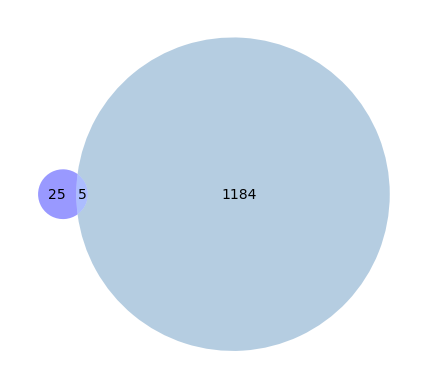

In [53]:
### Graph the overlap between deeplocpro - extracellular, and  Uniprot-secreted annottions

# Create a Venn diagram
venn2([set(deeplocpro_secreted), set(uniprot_secreted)], ('', ''), set_colors=("Blue", "steelblue"))


# Display the plot
plt.title("")
plt.savefig("Secretion_Prediction_Pie.svg")
plt.show()

In [38]:
### Combine all extracellular/secreted annotations, create a subset of the taxanomy df above for extracellular/secreted proteins

comnbined_secreted_accs = list(set(deeplocpro_secreted + uniprot_secreted))
comnbined_secreted_accs

combined_taxa_df_secreted = pd.DataFrame()  

for i, r in combined_taxa_df.iterrows():
    if r['ACC'] in comnbined_secreted_accs:
        combined_taxa_df_secreted = pd.concat([combined_taxa_df_secreted, r.to_frame().T], ignore_index=True)
        
combined_taxa_df_secreted

,Query,Taxid,Tax name,Authority,Rank,Basionym,Basionym authority,Curator common name,Has type material,Group name,...,Order name,Order taxid,Family name,Family taxid,Genus name,Genus taxid,Species name,Species taxid,Scientific name is formal,ACC
0,1341156,1341156,Ruminococcus albus SY3,NaN,STRAIN,NaN,NaN,NaN,no,firmicutes,...,Eubacteriales,186802.0,Oscillospiraceae,216572.0,Ruminococcus,1263.0,Ruminococcus albus,1264,False,A0A011VUM0
1,95486,95486,Burkholderia cenocepacia,Vandamme et al. 2003,SPECIES,NaN,NaN,NaN,yes,b-proteobacteria,...,Burkholderiales,80840.0,Burkholderiaceae,119060.0,Burkholderia,32008.0,Burkholderia cenocepacia,95486,True,A0A071MCE1
2,585425,585425,Synechococcus sp. KORDI-52,NaN,SPECIES,NaN,NaN,NaN,no,cyanobacteria,...,Synechococcales,1890424.0,Synechococcaceae,1890426.0,Synechococcus,1129.0,Synechococcus sp. KORDI-52,585425,False,A0A076HQJ4
3,1680,1680,Bifidobacterium adolescentis,Reuter 1963 (Approved Lists 1980),SPECIES,NaN,NaN,NaN,yes,high G+C Gram-positive bacteria,...,Bifidobacteriales,85004.0,Bifidobacteriaceae,31953.0,Bifidobacterium,1678.0,Bifidobacterium adolescentis,1680,True,A0A076JKV6
4,29343,29343,[Clostridium] cellulosi,Yanling et al. 1991,SPECIES,NaN,NaN,NaN,yes,firmicutes,...,Eubacteriales,186802.0,Oscillospiraceae,216572.0,NaN,NaN,[Clostridium] cellulosi,29343,True,A0A078KTQ4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,1400863,1400863,Candidatus Competibacter denitrificans Run_A_D11,NaN,STRAIN,NaN,NaN,NaN,no,g-proteobacteria,...,NaN,NaN,Candidatus Competibacteraceae,1400857.0,Candidatus Competibacter,221279.0,Candidatus Competibacter denitrificans,1400862,False,W6M9Z9
1210,1408889,1408889,Clostridium tyrobutyricum DIVETGP,NaN,STRAIN,NaN,NaN,NaN,no,firmicutes,...,Eubacteriales,186802.0,Clostridiaceae,31979.0,Clostridium,1485.0,Clostridium tyrobutyricum,1519,False,W6N3Z2
1211,1341157,1341157,Ruminococcus flavefaciens 007c,NaN,STRAIN,NaN,NaN,NaN,no,firmicutes,...,Eubacteriales,186802.0,Oscillospiraceae,216572.0,Ruminococcus,1263.0,Ruminococcus flavefaciens,1265,False,W7UI54
1212,1421016,1421016,Thermoanaerobacterium aotearoense SCUT27,NaN,STRAIN,NaN,NaN,NaN,no,firmicutes,...,Thermoanaerobacterales,68295.0,Thermoanaerobacteraceae,186814.0,Thermoanaerobacterium,28895.0,Thermoanaerobacterium aotearoense,47490,False,W9E8S8


In [42]:
#make taxa specific sub-dataframes for extracellular/secreted proteins
phylum_plot_df_secreted = get_taxa_ratios(combined_taxa_df_secreted, "Phylum name")
  
print(phylum_plot_df_secreted)
    
    
    
family_plot_df_secreted = get_taxa_ratios(combined_taxa_df_secreted, "Family name")
  
print(family_plot_df_secreted)
    
genus_plot_df_secreted = get_taxa_ratios(combined_taxa_df_secreted, "Genus name")
  
print(genus_plot_df_secreted)

species_plot_df_secreted = get_taxa_ratios(combined_taxa_df_secreted, "Species name")
  
print(species_plot_df_secreted)

          Level                          Label       Perc
0   Phylum name                      Bacillota  20.757825
1   Phylum name                 Pseudomonadota  23.558484
2   Phylum name                Cyanobacteriota  29.983526
3   Phylum name                 Actinomycetota   9.060956
4   Phylum name  Candidatus Collieribacteriota   0.494234
5   Phylum name        Thermodesulfobacteriota   3.212521
6   Phylum name              Verrucomicrobiota   4.695222
7   Phylum name                   Bacteroidota   1.647446
8   Phylum name                            NaN   1.317957
9   Phylum name                 Lentisphaerota   1.317957
10  Phylum name                  Spirochaetota   1.235585
11  Phylum name     Candidatus Melainabacteria   0.164745
12  Phylum name                Planctomycetota   0.164745
13  Phylum name                    Myxococcota   0.823723
14  Phylum name                   Thermotogota   0.576606
15  Phylum name     Candidatus Zixiibacteriota   0.082372
16  Phylum nam

/tmp/ipykernel_3961946/3913896516.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_3961946/3913896516.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_3961946/3913896516.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_3961946/3913896516.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

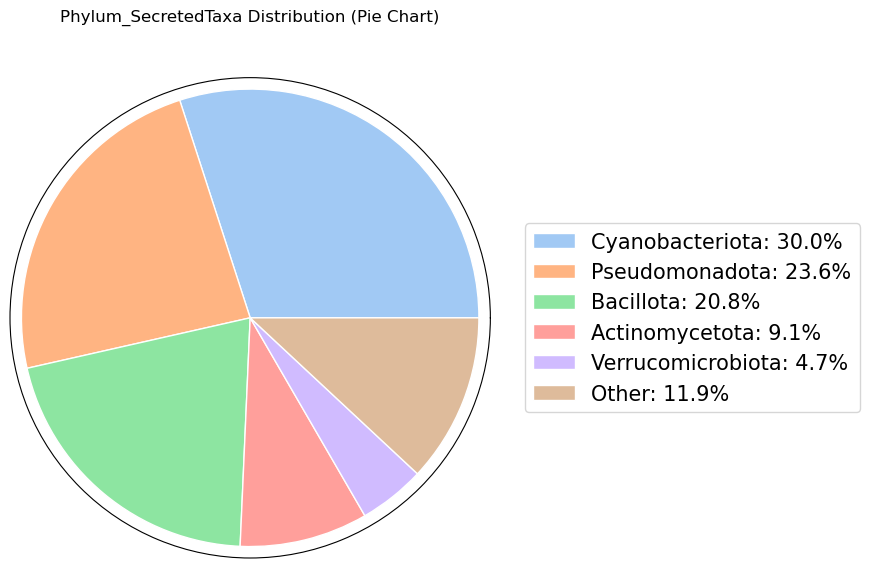

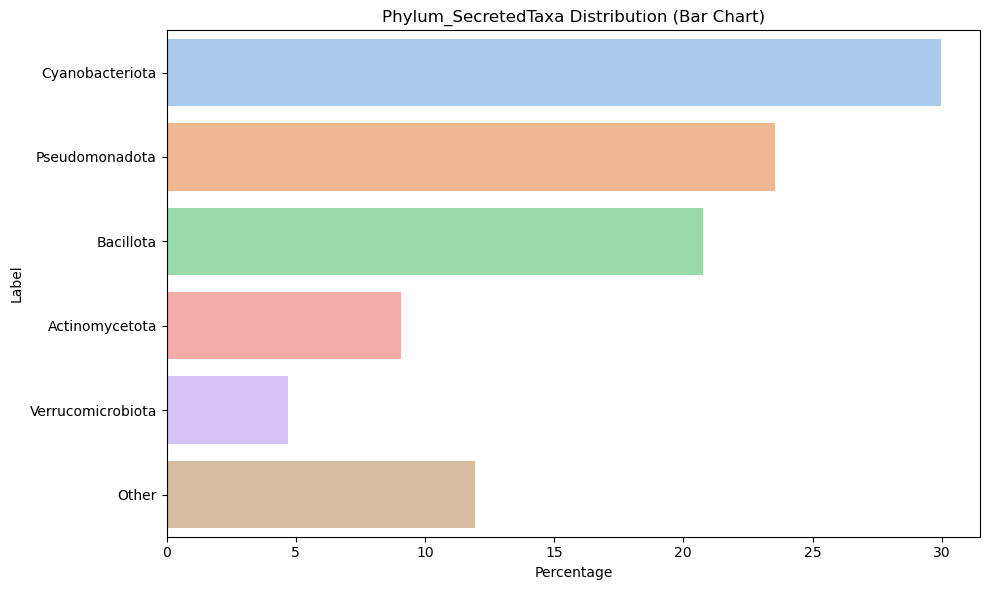

,Level,Label,Perc
0,Phylum name,Cyanobacteriota,29.983526
1,Phylum name,Pseudomonadota,23.558484
2,Phylum name,Bacillota,20.757825
3,Phylum name,Actinomycetota,9.060956
4,Phylum name,Verrucomicrobiota,4.695222
5,Phylum name,Other,11.943987


In [46]:
plot_taxa_distribution(phylum_plot_df_secreted, top_n=5, title_prefix='Phylum_Secreted')
